In [36]:
import pathlib
import gpytorch

from matplotlib import pyplot as plt
import numpy as np
import torch
from torcheval.metrics.functional import r2_score

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Load env dataset and preprocess

In [37]:
load_dir = "datasets/Bikes/n_centroids_116/None/1"
path = pathlib.Path(load_dir) / "replay_buffer.npz"
buffer = np.load(path)
next_obs = torch.tensor(buffer["next_obs"], dtype=torch.float32)
obs = torch.tensor(buffer["obs"], dtype=torch.float32)
act = torch.round(torch.tensor(buffer["action"], dtype=torch.float32))
reward = torch.tensor(buffer["reward"], dtype=torch.float32)
print(obs.shape, act.shape)

num_centroids = int(load_dir.split("/")[-3].split("_")[-1])
num_actions = int(load_dir.split("/")[-1])
if num_actions==1:
    bikes_per_truck = 8
elif num_actions==1:
    bikes_per_truck = 6
else:
    bikes_per_truck = 3
print(num_centroids, num_actions)
map_obs = {
    "bikes_distr": slice(0, num_centroids),
    "day": slice(num_centroids, num_centroids+1),
    "day_of_week": slice(num_centroids+1, num_centroids+2),
    "demands": slice(num_centroids+2, 2+num_centroids+num_actions),
    "month": slice(2+num_centroids+num_actions, 3+num_centroids+num_actions),
    "time_counter": slice(3+num_centroids+num_actions, 4+num_centroids+num_actions),
}
# num_trucks = act.shape[-1] // 2
# map_act = {
#     "truck_centroid": slice(0, num_trucks),
#     "truck_num_bikes": slice(num_trucks, 2 * num_trucks),
# }
num_trucks = act.shape[-1]
map_act = {
    "truck_centroid": slice(0, num_trucks),
}

print(map_obs)
print(map_act)

torch.Size([1000, 121]) torch.Size([1000, 5])
116 1
{'bikes_distr': slice(0, 116, None), 'day': slice(116, 117, None), 'day_of_week': slice(117, 118, None), 'demands': slice(118, 119, None), 'month': slice(119, 120, None), 'time_counter': slice(120, 121, None)}
{'truck_centroid': slice(0, 5, None)}


Compute delta bikes and obs += delta_bikes

In [38]:
obs_before_action = obs.clone()

resize = False
while obs.ndim < 3:
    assert act.ndim == obs.ndim
    obs = obs[None, ...]
    act = act[None, ...]
    resize = True

ensemble_size = obs.shape[0]
batch_size = obs.shape[1]
distr_size = len(obs[0, 0, map_obs["bikes_distr"]])  # self.map_obs["bikes_distr"]

# Compute delta_bikes in a parallel way
delta_bikes = np.zeros((ensemble_size, batch_size, distr_size), dtype=int)
truck_centroids = act[..., map_act["truck_centroid"]]  # self.map_act["truck_centroid"]
if map_act.get("truck_num_bikes", None) is not None:
    truck_bikes_ = act[..., map_act["truck_num_bikes"]]
else:
    truck_bikes_ = torch.ones_like(truck_centroids)*bikes_per_truck
truck_bikes = truck_bikes_.clone()
n = distr_size
truck_centroids = np.reshape(
    truck_centroids, (truck_centroids.shape[0] * truck_centroids.shape[1], -1)
)
offset = np.arange(truck_centroids.shape[0])[..., None]
truck_centroids_offset = truck_centroids + offset * n
unq, inv = np.unique(truck_centroids_offset.ravel(), return_inverse=True)
unq = unq.astype(int)
sol = np.bincount(inv, truck_bikes.ravel())
delta_bikes[
    unq // (batch_size * n),
    (unq % (batch_size * n)) // n,
    (unq % (batch_size * n)) % n,
] = sol

if resize:
    delta_bikes = delta_bikes.reshape((batch_size, -1))
    act = act.reshape((batch_size, -1))
    obs = obs.reshape((batch_size, -1))

# Update obs
obs[..., map_obs["bikes_distr"]] += delta_bikes  # self.map_obs["bikes_distr"]

assert torch.all(
    torch.sum(obs - obs_before_action, axis=-1)
    == torch.sum(truck_bikes_, axis=-1)
)

print(delta_bikes.shape)
print(act[..., map_act["truck_centroid"]].shape)

# Super long check to see if preprocess is good, and it is so far
# for obs_, previous_obs_, truck_centroids, truck_num_bikes in zip(
#     obs,
#     obs_before_action,
#     act[..., map_act["truck_centroid"]],
#     truck_bikes_[0],
# ):
#     bikes_idx = torch.nonzero(truck_num_bikes, as_tuple=True)[0]
#     truck_centroids = truck_centroids[bikes_idx]
#     centroids_new_bikes = torch.nonzero(obs_ - previous_obs_, as_tuple=True)[0]
#     print(torch.sort(centroids_new_bikes).values)
#     print(torch.unique(truck_centroids))
#     print(torch.sort(centroids_new_bikes).values in torch.unique(truck_centroids))
#     assert torch.sort(centroids_new_bikes).values in torch.unique(truck_centroids)

(1000, 116)
torch.Size([1000, 5])


Create x and y from obs and next_obs

In [39]:
dataset_size = 1000
input_obs_keys = ["bikes_distr", "demands", "time_counter"]
input_act_keys = []  # not implemented
output_keys = []

input_mask = np.zeros(obs.shape[-1])
for key in input_obs_keys:
    input_mask[map_obs[key]] = 1
input_mask = np.ma.make_mask(input_mask)

output_mask = np.zeros(obs.shape[-1])
for key in output_keys:
    output_mask[map_obs[key]] = 1
output_mask = np.ma.make_mask(output_mask)

assert obs.ndim == 2
assert next_obs.ndim == 2
x = obs[:dataset_size, input_mask]

if not np.any(output_mask):
    y = None
    print(x.shape, None)
else:
    y = next_obs[:dataset_size, output_mask]
    print(x.shape, y.shape)

torch.Size([1000, 118]) None


Additional input features

In [40]:
# Maybe add a date proxy, weather ? holiday, week-end ??

Additional output preds (e.g. reward)

In [41]:
learned_rewards = True
if learned_rewards:
    reward_ = reward[:dataset_size, ...].unsqueeze(-1)
    if y is not None:
        print(y.shape, reward_.shape)
        y = torch.cat([y, reward_], dim=-1)
    else:
        y = reward_
    print(y.shape)

torch.Size([1000, 1])


Split into train_x, test_x and train_y, test_y

In [42]:
test_split_ratio = 0.2

train_x = x[int(test_split_ratio * dataset_size) :, ...]
train_y = y[int(test_split_ratio * dataset_size) :, ...]
test_x = x[: int(test_split_ratio * dataset_size), ...]
test_y = y[: int(test_split_ratio * dataset_size), ...]

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([800, 118]) torch.Size([800, 1]) torch.Size([200, 118]) torch.Size([200, 1])


### 2. Train model

Linear regression

In [43]:
from src.model.linear_regression import LinearRegression

learningRate = 0.05
epochs = 2000
eval_epoch_freq = 1
in_size = train_x.shape[-1]
out_size = train_y.shape[-1]
device = "cpu"
lr_model = LinearRegression(in_size, out_size, device)
criterion = torch.nn.MSELoss()
metric = r2_score
optimizer = torch.optim.SGD(lr_model.parameters(), lr=learningRate)

In [44]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    torch.manual_seed(epoch)
    idx = torch.randperm(train_x.shape[0])
    train_x = train_x[idx, :]
    train_y = train_y[idx, :]
    idx = torch.randperm(test_x.shape[0])
    test_x = test_x[idx, :]
    test_y = test_y[idx, :]
    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = lr_model(train_x)

    # get loss for the predicted output
    loss = criterion(outputs, train_y)
    train_losses.append(loss.item())
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    # Compute metric
    train_metric = metric(outputs, train_y)
    train_metrics.append(train_metric)

    print("epoch {}, loss {}, R2 {}".format(epoch, loss.item(), train_metric))

    if epoch % eval_epoch_freq == 0:
        with torch.no_grad():  # we don't need gradients in the testing phase
            preds = lr_model(test_x)
            test_loss = criterion(preds, test_y)
            test_losses.append(test_loss.item())
            # Compute metric
            test_metric = metric(preds, test_y)
            test_metrics.append(test_metric)
            print("Eval loss {}, R2 {}".format(test_loss.item(), test_metric))

epoch 0, loss 0.20625297725200653, R2 -45.159244537353516
Eval loss 0.19292829930782318, R2 -51.57004165649414
epoch 1, loss 0.1809321939945221, R2 -39.49248123168945
Eval loss 0.170202374458313, R2 -45.3775634765625
epoch 2, loss 0.15883634984493256, R2 -34.54744338989258
Eval loss 0.150415301322937, R2 -39.98589324951172
epoch 3, loss 0.13970321416854858, R2 -30.265459060668945
Eval loss 0.13328276574611664, R2 -35.317527770996094
epoch 4, loss 0.12321897596120834, R2 -26.57630729675293
Eval loss 0.11849617213010788, R2 -31.288410186767578
epoch 5, loss 0.10905644297599792, R2 -23.406740188598633
Eval loss 0.10575038194656372, R2 -27.815372467041016
epoch 6, loss 0.09690022468566895, R2 -20.68619155883789
Eval loss 0.0947607234120369, R2 -24.820858001708984
epoch 7, loss 0.08646103739738464, R2 -18.349905014038086
Eval loss 0.08527156710624695, R2 -22.23520851135254
epoch 8, loss 0.07748223096132278, R2 -16.340456008911133
Eval loss 0.07705922424793243, R2 -19.99747085571289
epoch 9,

epoch 191, loss 0.004344270098954439, R2 0.027756035327911377
Eval loss 0.004012386314570904, R2 -0.09331440925598145
epoch 192, loss 0.004338286817073822, R2 0.029095053672790527
Eval loss 0.0040042949840426445, R2 -0.09110963344573975
epoch 193, loss 0.004332360811531544, R2 0.03042137622833252
Eval loss 0.003996291663497686, R2 -0.08892881870269775
epoch 194, loss 0.004326491616666317, R2 0.03173482418060303
Eval loss 0.003988374024629593, R2 -0.08677136898040771
epoch 195, loss 0.004320676438510418, R2 0.03303605318069458
Eval loss 0.003980540204793215, R2 -0.08463668823242188
epoch 196, loss 0.004314916208386421, R2 0.034325361251831055
Eval loss 0.0039727878756821156, R2 -0.08252441883087158
epoch 197, loss 0.00430920859798789, R2 0.035602688789367676
Eval loss 0.0039651175029575825, R2 -0.08043432235717773
epoch 198, loss 0.004303553141653538, R2 0.036868274211883545
Eval loss 0.003957525826990604, R2 -0.07836568355560303
epoch 199, loss 0.0042979479767382145, R2 0.0381228327751

<Figure size 640x480 with 0 Axes>

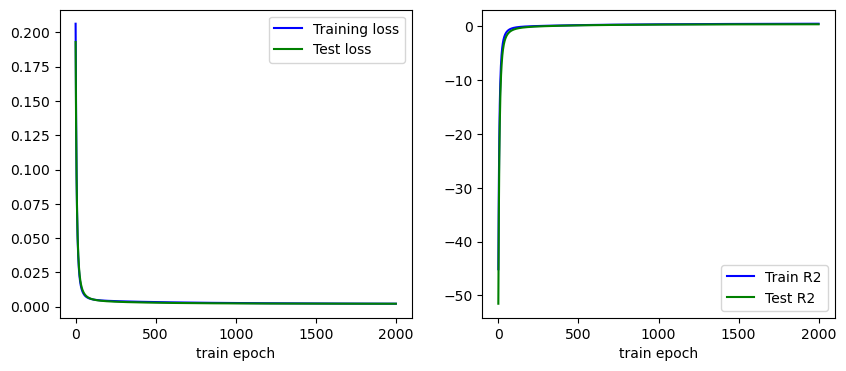

In [45]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, "b", label="Training loss")
ax[0].plot(test_losses, "g", label="Test loss")
ax[1].plot(train_metrics, "b", label="Train R2")
ax[1].plot(test_metrics, "g", label="Test R2")
ax[0].set_xlabel("train epoch")
ax[1].set_xlabel("train epoch")
ax[0].legend(loc="best")
ax[1].legend(loc="best")
plt.show()

<Figure size 640x480 with 0 Axes>

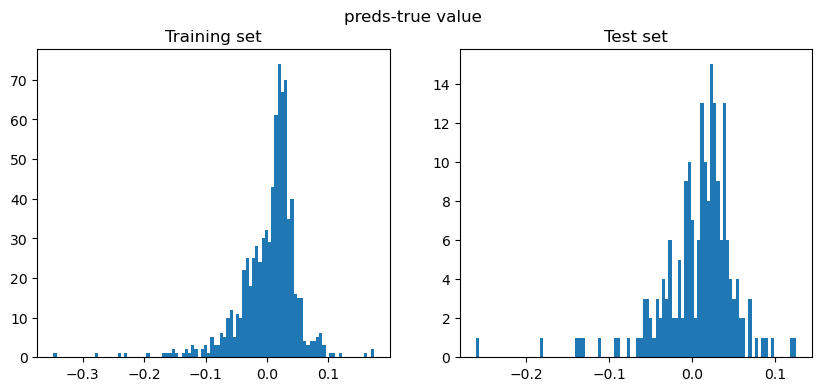

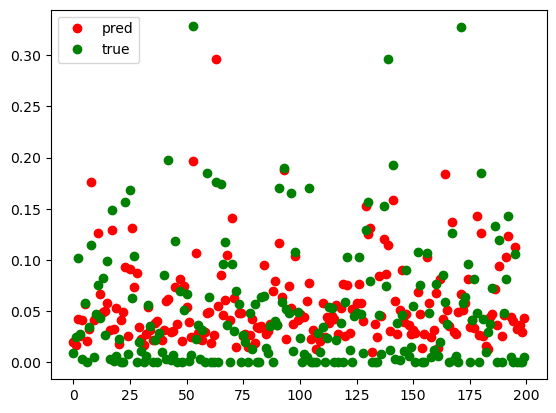

Parameter containing:
tensor([[ 0.0657,  0.0536,  0.0166,  ...,  0.0525, -0.0736, -0.0437],
        [ 0.0402,  0.0276, -0.0071,  ..., -0.0740,  0.0231,  0.0593],
        [ 0.0371, -0.0498, -0.0053,  ..., -0.0277, -0.0719, -0.0565],
        ...,
        [ 0.0859, -0.0253,  0.0561,  ...,  0.0085, -0.0337,  0.0931],
        [-0.0799,  0.0479, -0.0414,  ...,  0.0108, -0.0743, -0.0495],
        [ 0.0431, -0.0487,  0.0077,  ..., -0.0086,  0.0056,  0.0011]],
       requires_grad=True) Parameter containing:
tensor([-0.1835], requires_grad=True)
Parameter containing:
tensor([[ 0.0657,  0.0536,  0.0166,  ...,  0.0525, -0.0736, -0.0437],
        [ 0.0402,  0.0276, -0.0071,  ..., -0.0740,  0.0231,  0.0593],
        [ 0.0371, -0.0498, -0.0053,  ..., -0.0277, -0.0719, -0.0565],
        ...,
        [ 0.0859, -0.0253,  0.0561,  ...,  0.0085, -0.0337,  0.0931],
        [-0.0799,  0.0479, -0.0414,  ...,  0.0108, -0.0743, -0.0495],
        [ 0.0431, -0.0487,  0.0077,  ..., -0.0086,  0.0056,  0.0011]],
 

In [46]:
if y.shape[-1] == 1:

    with torch.no_grad():  # we don't need gradients in the testing phase
        train_preds = lr_model(train_x)
        test_preds = lr_model(test_x)

    relative_train_preds = train_preds - train_y
    relative_test_preds = test_preds - test_y

    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Train bar plots
    n_bins = 100
    counts, bins = np.histogram(relative_train_preds, bins=n_bins)
    ax[0].hist(bins[:-1], bins, weights=counts)
    ax[0].title.set_text("Training set")

    # Test bar plots
    n_bins = 100
    counts, bins = np.histogram(relative_test_preds, bins=n_bins)
    ax[1].hist(bins[:-1], bins, weights=counts)
    ax[1].title.set_text("Test set")

    fig.suptitle("preds-true value")
    plt.show()

else:

    with torch.no_grad():  # we don't need gradients in the testing phase
        train_preds = lr_model(train_x)
        test_preds = lr_model(test_x)

    relative_train_preds_mean = torch.mean(train_preds - train_y, axis=0)
    relative_train_preds_std = torch.std(train_preds - train_y, axis=0)
    relative_test_preds_mean = torch.mean(test_preds - test_y, axis=0)
    relative_test_preds_std = torch.std(test_preds - test_y, axis=0)

    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Colors and labels
    if len(relative_train_preds_mean) < num_centroids:
        raise ValueError("Predicted outputs are weird")
    if len(relative_train_preds_mean) == num_centroids:
        color = "green"
        label = "centroids"
    else:
        colors = ["green"] * num_centroids
        colors.append("red")
        label = ["centroids"] * num_centroids
        label.append("reward")

    # Train bar plots
    x = torch.arange(0, len(relative_train_preds_mean), 1)
    ax[0].bar(x, relative_train_preds_mean, color=colors, label=label)
    for pos, y, err, color in zip(
        x, relative_train_preds_mean, relative_train_preds_std, colors
    ):
        ax[0].errorbar(pos, y, err, lw=2, capsize=2, capthick=1, color=color, alpha=0.3)
        # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
    ax[0].title.set_text("Training set")

    # Test bar plots
    ax[1].bar(x, relative_test_preds_mean, color=colors, label=label)
    for pos, y, err, color in zip(
        x, relative_test_preds_mean, relative_test_preds_std, colors
    ):
        ax[1].errorbar(pos, y, err, lw=2, capsize=2, capthick=1, color=color, alpha=0.3)
    ax[1].title.set_text("Test set")

    fig.suptitle("preds-true value for each centroid (and reward if learned)")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="best")
    plt.show()

plt.plot(test_preds, 'ro', label='pred')
plt.plot(test_y, 'go', label='true')
plt.legend()
plt.show()

print(lr_model.linear1.weight, lr_model.linear2.bias)
print(lr_model.linear1.weight, lr_model.linear2.bias)

With model trainer

In [47]:
# TEST with model trainer
import omegaconf

from src.env.bikes import Bikes
from src.model.simple import Simple, FactoredSimple
from src.model.dict_model_wrapper import OneDTransitionRewardModelDictSpace
from src.util.model_trainer import ModelTrainerOverriden, MultiModelsTrainer
from src.util.replay_buffer import ReplayBufferOverriden
import mbrl.util.common

# WARNING: Make sure that it makes sense with trained model above

# Env config
env_config = {
    "num_trucks": 5,  # 10
    "action_per_day": 8,
    "next_day_method": "random",  # sequential
    "initial_distribution": "zeros",
    "bikes_per_truck": 5,
    "start_walk_dist_max": 0.2,
    "end_walk_dist_max": 1000.0,
    "trip_duration": 0.5,
    "past_trip_data": "src/env/bikes_data/all_trips_LouVelo_merged.csv",
    "weather_data": "src/env/bikes_data/weather_data.csv",
    "centroids_coord": "src/env/bikes_data/LouVelo_centroids_coords.npy",
    # "centroids_idx": #[93,83,80,98,6,84,87,99,56,97], #Number of centroids or list of indices
    "station_dependencies": None,  # src/env/bikes_data/factors_radius_3.npy
}

# Params
seed = 1
device = "cpu"
target_is_delta = True #Falses
normalize = False
use_double_dtype = False  # True
optim_lr = learningRate
model_wd = 0.#000001
model_batch_size = dataset_size
validation_ratio = test_split_ratio
num_epochs = epochs

# Env
env_config = omegaconf.DictConfig(env_config)
env = Bikes(env_config, render_mode=None)

obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

# Seed
# rng = np.random.default_rng(seed=seed)
# torch_generator = torch.Generator(device=device)
# if seed is not None:
#     torch_generator.manual_seed(seed)
rng = np.random.default_rng(seed=0)
torch.manual_seed(0)

# Dynamics model
from src.model.simple import Simple, FactoredSimple
from src.model.gaussian_process import MultiOutputGP
from src.util.util import get_base_dir_path

base_dir = get_base_dir_path()
adjacency = np.load(base_dir + "src/env/bikes_data/factors_radius_1-2.npy")
factors = [[i for i, e in enumerate(station) if e != 0] for station in adjacency]
# Compute the additional scopes
input_obs_keys = input_obs_keys
input_act_keys = input_act_keys
n_scopes_before = 0
n_scopes_after = 0
before = True
for key in env.dict_observation_space.keys():
    if key in input_obs_keys:
        if key != "bikes_distr":
            scope_length = env.dict_observation_space[key].shape[0]
            if before:
                n_scopes_before += scope_length
            else:
                n_scopes_after += scope_length
        else:
            before = False
    elif key == "bikes_distr":
        raise ValueError(
            "Key 'bikes_distr' must be in the input keys"
            "when using a factored model (useless otherwise)"
        )
for key in input_act_keys:
    n_scopes_after += env.dict_action_space[key].shape[0]

scopes_after = [i + adjacency.shape[0] for i in range(n_scopes_after)]
factors = [factor + scopes_after for factor in factors]
factors = [[scope + n_scopes_before for scope in factor] for factor in factors]
scopes_before = [i for i in range(n_scopes_before)]
factors = [scopes_before + factor for factor in factors]
dynamics_model = OneDTransitionRewardModelDictSpace(
    Simple(in_size, out_size, device), #factors, num_layers=2, hid_size=100),
    map_obs=env.map_obs,
    map_act=env.map_act,
    rescale_obs=env.rescale_obs,
    rescale_act=env.rescale_act,
    model_input_obs_key=input_obs_keys,
    model_input_act_key=input_act_keys,
    model_output_key=output_keys,
    obs_preprocess_fn=env.obs_preprocess_fn,
    obs_postprocess_fn=env.obs_postprocess_fn,
    target_is_delta=target_is_delta,
    normalize=normalize,
    normalize_double_precision=use_double_dtype,
    learned_rewards=learned_rewards,
    no_delta_list=None,
    num_elites=None,
)

# Model trainer
model_trainer = ModelTrainerOverriden(
    model=dynamics_model,
    optim_lr=optim_lr,
    weight_decay=model_wd,
    logger=None,
)

# Load replay Buffer
dtype = np.double if use_double_dtype else np.float32
replay_buffer = ReplayBufferOverriden(
    dataset_size,
    obs_shape,
    act_shape,
    obs_type=dtype,
    action_type=dtype,
    reward_type=dtype,
    rng=rng,
    # max_trajectory_length=None,
)

load_dir = pathlib.Path(load_dir)
replay_buffer.load(str(load_dir), num_to_store=500)

dataset_train, dataset_val = mbrl.util.common.get_basic_buffer_iterators(
    replay_buffer,
    model_batch_size,
    validation_ratio,
    ensemble_size=len(dynamics_model),
    shuffle_each_epoch=True,
    bootstrap_permutes=False,
)

if hasattr(dynamics_model, "update_normalizer"):
    dynamics_model.update_normalizer(replay_buffer.get_all())
train_losses, test_losses, train_metrics, test_metrics = model_trainer.train(
    dataset_train,
    dataset_val,
    num_epochs=num_epochs,
    patience=num_epochs,
    evaluate=True,
    debug=True,
)

FileNotFoundError: [Errno 2] No such file or directory: 'src/env/bikes_data/LouVelo_centroids_coords.npy'

<Figure size 640x480 with 0 Axes>

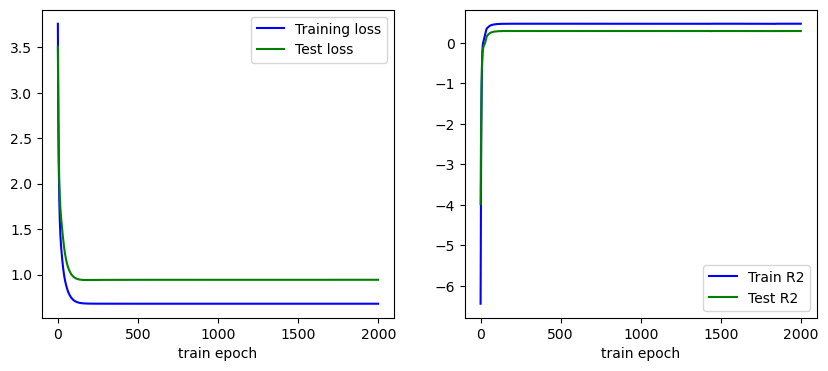

In [ ]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, "b", label="Training loss")
ax[0].plot(test_losses, "g", label="Test loss")
ax[1].plot(train_metrics, "b", label="Train R2")
ax[1].plot(test_metrics, "g", label="Test R2")
ax[0].set_xlabel("train epoch")
ax[1].set_xlabel("train epoch")
ax[0].legend(loc="best")
ax[1].legend(loc="best")
plt.show()

<Figure size 640x480 with 0 Axes>

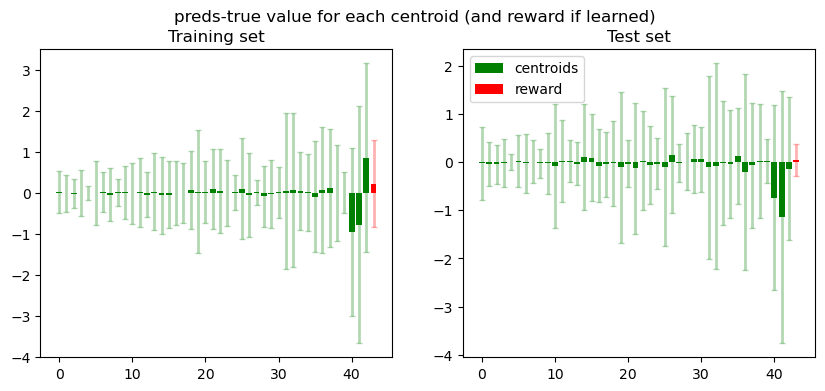

In [ ]:
with torch.no_grad():  # we don't need gradients in the testing phase
    train_preds = dynamics_model.model(train_x)
    test_preds = dynamics_model.model(test_x)

relative_train_preds_mean = torch.mean(train_preds - train_y, axis=0)
relative_train_preds_std = torch.std(train_preds - train_y, axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y, axis=0)
relative_test_preds_std = torch.std(test_preds - test_y, axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Colors and labels
if len(relative_train_preds_mean) < num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean) == num_centroids:
    color = "green"
    label = "centroids"
else:
    colors = ["green"] * num_centroids
    colors.append("red")
    label = ["centroids"] * num_centroids
    label.append("reward")

# Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(x, relative_train_preds_mean, color=colors, label=label)
for pos, y, err, color in zip(
    x, relative_train_preds_mean, relative_train_preds_std, colors
):
    ax[0].errorbar(pos, y, err, lw=2, capsize=2, capthick=1, color=color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text("Training set")

# Test bar plots
ax[1].bar(x, relative_test_preds_mean, color=colors, label=label)
for pos, y, err, color in zip(
    x, relative_test_preds_mean, relative_test_preds_std, colors
):
    ax[1].errorbar(pos, y, err, lw=2, capsize=2, capthick=1, color=color, alpha=0.3)
ax[1].title.set_text("Test set")

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="best")
plt.show()

Neural Network

In [48]:
from src.model.simple import Simple

# Hyperparams
learningRate = 0.001
weight_decay = 0.001
optim_eps = 1e-8

epochs = 500
batch_size = 256
eval_epoch_freq = 1
in_size = train_x.shape[-1]
out_size = train_y.shape[-1]
device = "cpu"
NN_model = Simple(
    in_size,
    out_size,
    device,
    num_layers=2,
    hid_size=100,
)
criterion = torch.nn.MSELoss()
metric = r2_score
optimizer = torch.optim.Adam(
    NN_model.parameters(),
    lr=learningRate,
    weight_decay=weight_decay,
    eps=optim_eps,
)
# torch.optim.SGD(model.parameters(), lr=learningRate)

In [49]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    k = 0
    l = batch_size
    batch_loss = []
    while l < train_x.shape[0]:
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = NN_model(train_x)

        # get loss for the predicted output
        loss = criterion(outputs, train_y)
        batch_loss.append(loss.item())
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        # Update k,l
        k = l
        l = min(l + batch_size, train_x.shape[0])

    # Append train loss
    train_losses.append(np.mean(batch_loss))

    # Compute metric
    train_metric = metric(outputs, train_y)
    train_metrics.append(train_metric)

    print("epoch {}, loss {}, R2 {}".format(epoch, loss.item(), train_metric))

    if epoch % eval_epoch_freq == 0:
        with torch.no_grad():  # we don't need gradients in the testing phase
            preds = NN_model(test_x)
            test_loss = criterion(preds, test_y)
            test_losses.append(test_loss.item())
            # Compute metric
            test_metric = metric(preds, test_y)
            test_metrics.append(test_metric)
            print("Eval loss {}, R2 {}".format(test_loss.item(), test_metric))

epoch 0, loss 0.30308693647384644, R2 -66.83059692382812
Eval loss 0.2145693153142929, R2 -57.46688461303711
epoch 1, loss 0.17365333437919617, R2 -37.86347198486328
Eval loss 0.16188088059425354, R2 -43.11008071899414
epoch 2, loss 0.06756393611431122, R2 -14.120753288269043
Eval loss 0.11564362794160843, R2 -30.511133193969727
epoch 3, loss 0.05309712514281273, R2 -10.883091926574707
Eval loss 0.08103824406862259, R2 -21.08169174194336
epoch 4, loss 0.04749802500009537, R2 -9.63001823425293
Eval loss 0.10375602543354034, R2 -27.271942138671875
epoch 5, loss 0.026001224294304848, R2 -4.819052219390869
Eval loss 0.06792192906141281, R2 -17.507694244384766
epoch 6, loss 0.02438466250896454, R2 -4.4572672843933105
Eval loss 0.0675790086388588, R2 -17.41425323486328


epoch 7, loss 0.012605038471519947, R2 -1.8209972381591797
Eval loss 0.05825037881731987, R2 -14.872344017028809
epoch 8, loss 0.012127646245062351, R2 -1.7141571044921875
Eval loss 0.06556718796491623, R2 -16.866064071655273
epoch 9, loss 0.006834512576460838, R2 -0.5295581817626953
Eval loss 0.05495892092585564, R2 -13.975471496582031
epoch 10, loss 0.006336410529911518, R2 -0.41808342933654785
Eval loss 0.05355648696422577, R2 -13.593329429626465
epoch 11, loss 0.003644701326265931, R2 0.1843189001083374
Eval loss 0.053240593522787094, R2 -13.507253646850586
epoch 12, loss 0.003321455791592598, R2 0.25666099786758423
Eval loss 0.05704858899116516, R2 -14.54487419128418
epoch 13, loss 0.001795076415874064, R2 0.5982633829116821
Eval loss 0.05275578424334526, R2 -13.375150680541992
epoch 14, loss 0.0018354224739596248, R2 0.5892339944839478
Eval loss 0.051554709672927856, R2 -13.04787540435791
epoch 15, loss 0.0008599685388617218, R2 0.8075397610664368
Eval loss 0.05233856663107872, R

<Figure size 640x480 with 0 Axes>

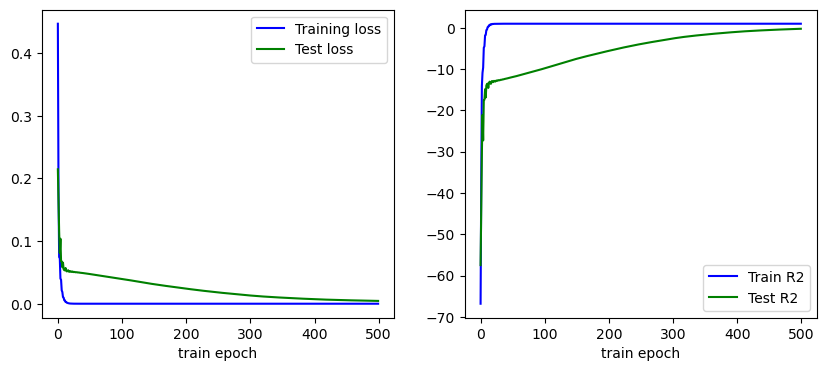

In [50]:
plt.clf()
offset = 0
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses[offset:], "b", label="Training loss")
ax[0].plot(test_losses[offset:], "g", label="Test loss")
ax[1].plot(train_metrics[offset:], "b", label="Train R2")
ax[1].plot(test_metrics[offset:], "g", label="Test R2")
ax[0].set_xlabel("train epoch")
ax[1].set_xlabel("train epoch")
ax[0].legend(loc="best")
ax[1].legend(loc="best")
plt.show()

<Figure size 640x480 with 0 Axes>

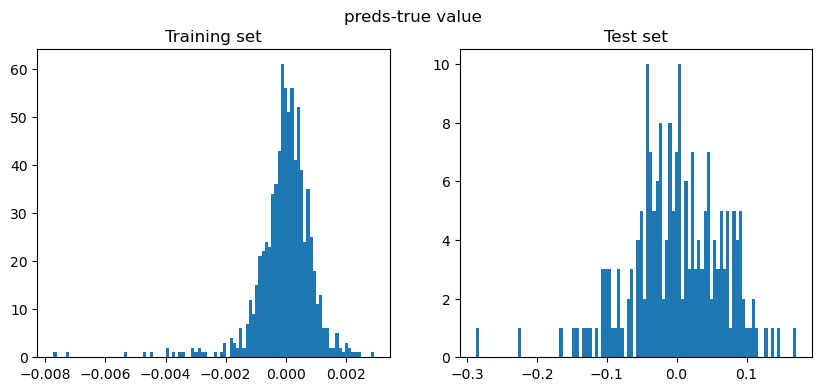

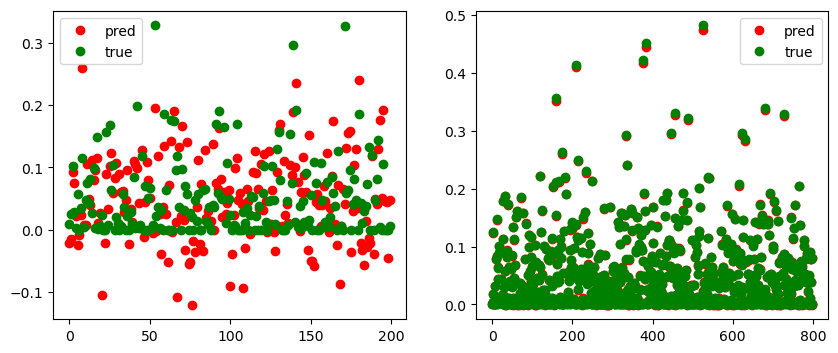

Parameter containing:
tensor([[ 0.0657,  0.0536,  0.0166,  ...,  0.0525, -0.0736, -0.0437],
        [ 0.0402,  0.0276, -0.0071,  ..., -0.0740,  0.0231,  0.0593],
        [ 0.0371, -0.0498, -0.0053,  ..., -0.0277, -0.0719, -0.0565],
        ...,
        [ 0.0859, -0.0253,  0.0561,  ...,  0.0085, -0.0337,  0.0931],
        [-0.0799,  0.0479, -0.0414,  ...,  0.0108, -0.0743, -0.0495],
        [ 0.0431, -0.0487,  0.0077,  ..., -0.0086,  0.0056,  0.0011]],
       requires_grad=True) Parameter containing:
tensor([-0.1835], requires_grad=True)
Parameter containing:
tensor([[ 0.0657,  0.0536,  0.0166,  ...,  0.0525, -0.0736, -0.0437],
        [ 0.0402,  0.0276, -0.0071,  ..., -0.0740,  0.0231,  0.0593],
        [ 0.0371, -0.0498, -0.0053,  ..., -0.0277, -0.0719, -0.0565],
        ...,
        [ 0.0859, -0.0253,  0.0561,  ...,  0.0085, -0.0337,  0.0931],
        [-0.0799,  0.0479, -0.0414,  ...,  0.0108, -0.0743, -0.0495],
        [ 0.0431, -0.0487,  0.0077,  ..., -0.0086,  0.0056,  0.0011]],
 

In [51]:
with torch.no_grad():  # we don't need gradients in the testing phase
    train_preds = NN_model(train_x)
    test_preds = NN_model(test_x)

relative_train_preds = train_preds - train_y
relative_test_preds = test_preds - test_y

if y.shape[-1] == 1:
    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Train bar plots
    n_bins = 100
    counts, bins = np.histogram(relative_train_preds, bins=n_bins)
    ax[0].hist(bins[:-1], bins, weights=counts)
    ax[0].title.set_text("Training set")

    # Test bar plots
    n_bins = 100
    counts, bins = np.histogram(relative_test_preds, bins=n_bins)
    ax[1].hist(bins[:-1], bins, weights=counts)
    ax[1].title.set_text("Test set")

    fig.suptitle("preds-true value")
    plt.show()

else:

    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Colors and labels
    if len(relative_train_preds_mean) < num_centroids:
        raise ValueError("Predicted outputs are weird")
    if len(relative_train_preds_mean) == num_centroids:
        color = "green"
        label = "centroids"
    else:
        colors = ["green"] * num_centroids
        colors.append("red")
        label = ["centroids"] * num_centroids
        label.append("reward")

    # Train bar plots
    x = torch.arange(0, len(relative_train_preds_mean), 1)
    ax[0].bar(x, relative_train_preds_mean, color=colors, label=label)
    for pos, y, err, color in zip(
        x, relative_train_preds_mean, relative_train_preds_std, colors
    ):
        ax[0].errorbar(pos, y, err, lw=2, capsize=2, capthick=1, color=color, alpha=0.3)
        # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
    ax[0].title.set_text("Training set")

    # Test bar plots
    ax[1].bar(x, relative_test_preds_mean, color=colors, label=label)
    for pos, y, err, color in zip(
        x, relative_test_preds_mean, relative_test_preds_std, colors
    ):
        ax[1].errorbar(pos, y, err, lw=2, capsize=2, capthick=1, color=color, alpha=0.3)
    ax[1].title.set_text("Test set")

    fig.suptitle("preds-true value for each centroid (and reward if learned)")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="best")
    plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(test_preds, 'ro', label='pred')
ax[0].plot(test_y, 'go', label='true')
ax[0].legend()
ax[1].plot(train_preds, 'ro', label='pred')
ax[1].plot(train_y, 'go', label='true')
ax[1].legend()
plt.show()

print(lr_model.linear1.weight, lr_model.linear2.bias)
print(lr_model.linear1.weight, lr_model.linear2.bias)

Gaussian process

In [94]:
from src.model.gaussian_process import MultiOutputGP

# Hyperparams
learningRate = 0.0001
weight_decay = 0
optim_eps = 1e-8
mean = "Linear"
kernel = "RBF"

epochs = 300
eval_epoch_freq = 1
in_size = train_x.shape[-1]
out_size = train_y.shape[-1]
device = "cpu"
GP_model = MultiOutputGP(in_size, out_size, device, mean, kernel)
mll = gpytorch.mlls.SumMarginalLogLikelihood(GP_model.likelihood, GP_model.gp)
metric = r2_score
optimizer = torch.optim.Adam(
    GP_model.parameters(),
    lr=learningRate,
    weight_decay=weight_decay,
    eps=optim_eps,
)
# torch.optim.SGD(model.parameters(), lr=learningRate)

dataset_size_gp = 1000
gp_idx_split = int(test_split_ratio * dataset_size_gp)

train_x_gp = x[gp_idx_split:dataset_size_gp, ...]
train_y_gp = y[gp_idx_split:dataset_size_gp, ...]
test_x_gp = x[:gp_idx_split, ...]
test_y_gp = y[:gp_idx_split, ...]

print(train_x_gp.shape, train_y_gp.shape, test_x_gp.shape, test_y_gp.shape)

torch.Size([800, 118]) torch.Size([800, 1]) torch.Size([200, 118]) torch.Size([200, 1])


In [95]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    # Set training mode REQUIRED FOR GP
    GP_model.gp.train()

    # Set the training data
    if epoch == 0:
        GP_model.set_train_data(train_x_gp, train_y_gp)

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = GP_model.forward()

    # get loss for the predicted output
    loss = -mll(outputs, GP_model.gp.train_targets)
    train_losses.append(loss.item())
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    # Compute metric
    train_pred_output = GP_model.likelihood(*outputs)
    train_pred_mean = torch.cat(
        [pred.mean.unsqueeze(-1) for pred in train_pred_output], axis=-1
    )
    train_metric = metric(train_pred_mean, train_y_gp)
    train_metrics.append(train_metric)

    print("epoch {}, loss {}, R2 {}".format(epoch, loss.item(), train_metric))

    if epoch % eval_epoch_freq == 0:
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            GP_model.gp.eval()
            GP_model.likelihood.eval()
            preds = GP_model.forward(test_x_gp)
            test_loss = -mll(
                preds, [test_y_gp[..., i] for i in range(len(GP_model.gp.models))]
            )
            test_losses.append(test_loss.item())
            # Compute metric
            test_pred_output = GP_model.likelihood(*preds)
            test_pred_mean = torch.cat(
                [pred.mean.unsqueeze(-1) for pred in test_pred_output], axis=-1
            )
            test_metric = metric(test_pred_mean, test_y_gp)
            test_metrics.append(test_metric)
            print("Eval loss {}, R2 {}".format(test_loss.item(), test_metric))

epoch 0, loss 1.0849229097366333, R2 -0.6303715705871582
Eval loss 1.0844556093215942, R2 -0.6620907783508301
epoch 1, loss 1.0848830938339233, R2 -0.6279984712600708
Eval loss 1.084416151046753, R2 -0.659407377243042
epoch 2, loss 1.084843397140503, R2 -0.6256300210952759
Eval loss 1.0843768119812012, R2 -0.6567294597625732
epoch 3, loss 1.084803819656372, R2 -0.6232662200927734
Eval loss 1.0843373537063599, R2 -0.654057502746582
epoch 4, loss 1.0847641229629517, R2 -0.620907187461853
Eval loss 1.084297776222229, R2 -0.6513911485671997
epoch 5, loss 1.0847243070602417, R2 -0.6185530424118042
Eval loss 1.0842584371566772, R2 -0.6487307548522949
epoch 6, loss 1.0846847295761108, R2 -0.616204023361206
Eval loss 1.0842190980911255, R2 -0.6460764408111572
epoch 7, loss 1.0846450328826904, R2 -0.613860011100769
Eval loss 1.0841796398162842, R2 -0.6434283256530762
epoch 8, loss 1.0846054553985596, R2 -0.6115207672119141
Eval loss 1.0841403007507324, R2 -0.6407860517501831
epoch 9, loss 1.084

<Figure size 640x480 with 0 Axes>

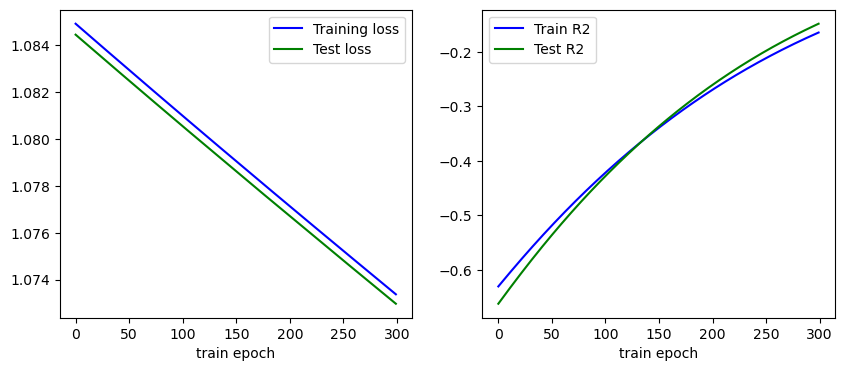

In [96]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, "b", label="Training loss")
ax[0].plot(test_losses, "g", label="Test loss")
ax[1].plot(train_metrics, "b", label="Train R2")
ax[1].plot(test_metrics, "g", label="Test R2")
ax[0].set_xlabel("train epoch")
ax[1].set_xlabel("train epoch")
ax[0].legend(loc="best")
ax[1].legend(loc="best")
plt.show()

torch.Size([800, 1]) torch.Size([200, 1])
torch.Size([800, 1]) torch.Size([800, 1]) torch.Size([200, 1]) torch.Size([200, 1])


<Figure size 640x480 with 0 Axes>

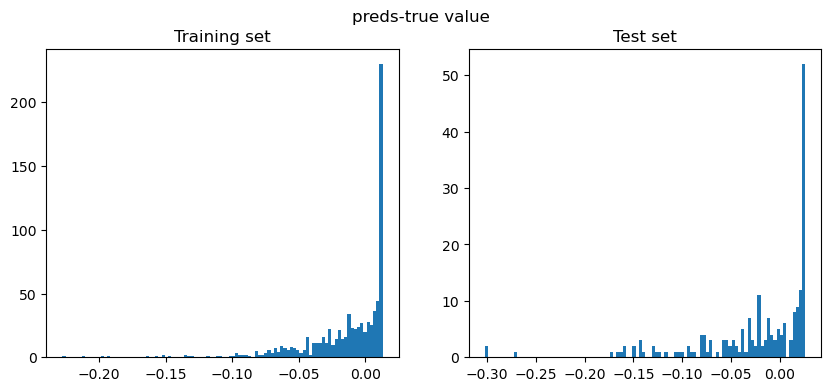

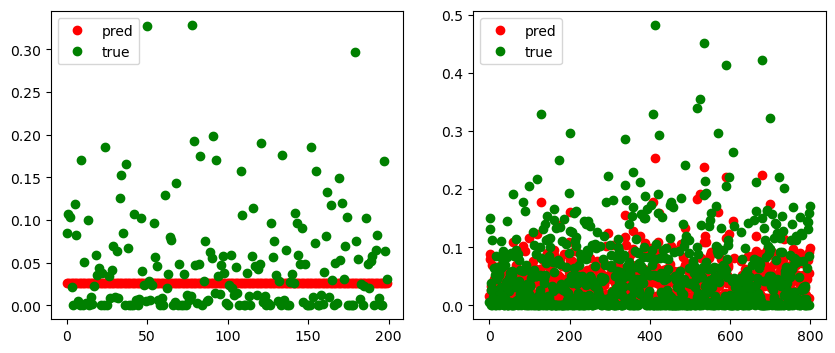

In [97]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_preds = GP_model.likelihood(*GP_model(train_x_gp))
    test_preds = GP_model.likelihood(*GP_model(test_x_gp))
    train_preds = torch.cat([pred.mean.unsqueeze(-1) for pred in train_preds], axis=-1)
    test_preds = torch.cat([pred.mean.unsqueeze(-1) for pred in test_preds], axis=-1)

relative_train_preds_mean = torch.mean(train_preds - train_y_gp, axis=0)
relative_train_preds_std = torch.std(train_preds - train_y_gp, axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y_gp, axis=0)
relative_test_preds_std = torch.std(test_preds - test_y_gp, axis=0)

print(train_y_gp.shape, test_y_gp.shape)
print(train_preds.shape,train_preds.shape,test_preds.shape,test_preds.shape)

if y.shape[-1] == 1:
    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Train bar plots
    n_bins = 100
    counts, bins = np.histogram(train_preds-train_y_gp, bins=n_bins)
    ax[0].hist(bins[:-1], bins, weights=counts)
    ax[0].title.set_text("Training set")

    # Test bar plots
    n_bins = 100
    counts, bins = np.histogram(test_preds-test_y_gp, bins=n_bins)
    ax[1].hist(bins[:-1], bins, weights=counts)
    ax[1].title.set_text("Test set")

    fig.suptitle("preds-true value")
    plt.show()

else:

    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Colors and labels
    if len(relative_train_preds_mean) < num_centroids:
        raise ValueError("Predicted outputs are weird")
    if len(relative_train_preds_mean) == num_centroids:
        color = "green"
        label = "centroids"
    else:
        colors = ["green"] * num_centroids
        colors.append("red")
        label = ["centroids"] * num_centroids
        label.append("reward")

    # Train bar plots
    x = torch.arange(0, len(relative_train_preds_mean), 1)
    ax[0].bar(x, relative_train_preds_mean, color=colors, label=label)
    for pos, y, err, color in zip(
        x, relative_train_preds_mean, relative_train_preds_std, colors
    ):
        ax[0].errorbar(pos, y, err, lw=2, capsize=2, capthick=1, color=color, alpha=0.3)
        # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
    ax[0].title.set_text("Training set")

    # Test bar plots
    ax[1].bar(x, relative_test_preds_mean, color=colors, label=label)
    for pos, y, err, color in zip(
        x, relative_test_preds_mean, relative_test_preds_std, colors
    ):
        ax[1].errorbar(pos, y, err, lw=2, capsize=2, capthick=1, color=color, alpha=0.3)
    ax[1].title.set_text("Test set")

    fig.suptitle("preds-true value for each centroid (and reward if learned)")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="best")
    plt.show()


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(test_preds, 'ro', label='pred')
ax[0].plot(test_y_gp, 'go', label='true')
ax[0].legend()
ax[1].plot(train_preds, 'ro', label='pred')
ax[1].plot(train_y_gp, 'go', label='true')
ax[1].legend()
plt.show()

In [98]:
# For a given output look at the confidence interval for each sample of the training and test sets

gp_id = 0

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_pred = GP_model.likelihood.likelihoods[gp_id](
        GP_model.gp.models[gp_id](train_x_gp)
    )
    test_pred = GP_model.likelihood.likelihoods[gp_id](
        GP_model.gp.models[gp_id](test_x_gp)
    )

    train_lower, train_upper = train_pred.confidence_region()
    mean_lower_train = np.mean(train_lower.numpy() - train_pred.mean.numpy())
    std_lower_train = np.std(train_lower.numpy() - train_pred.mean.numpy())
    mean_upper_train = np.mean(train_upper.numpy() - train_pred.mean.numpy())
    std_upper_train = np.std(train_upper.numpy() - train_pred.mean.numpy())
    test_lower, test_upper = test_pred.confidence_region()
    mean_lower_test = np.mean(test_lower.numpy() - test_pred.mean.numpy())
    std_lower_test = np.std(test_lower.numpy() - test_pred.mean.numpy())
    mean_upper_test = np.mean(test_upper.numpy() - test_pred.mean.numpy())
    std_upper_test = np.std(test_upper.numpy() - test_pred.mean.numpy())

    print(train_pred.mean.numpy().shape, test_pred.mean.numpy().shape)
    print(f"Lower train: {mean_lower_train}+-{std_lower_train}")
    print(f"Upper train: {mean_upper_train}+-{std_upper_train}")
    print(f"Lower test: {mean_lower_test}+-{std_lower_test}")
    print(f"Lower test: {mean_upper_test}+-{std_upper_test}")

(800,) (200,)
Lower train: -2.0174007415771484+-0.0
Upper train: 2.0174007415771484+-0.0
Lower test: -2.3294365406036377+-2.384185791015625e-07
Lower test: 2.3294365406036377+-2.384185791015625e-07


Benchmark: next_obs=obs (only dynamics, can't fake predict reward)

In [ ]:
criterion = torch.nn.MSELoss()
metric = r2_score

train_fake_preds = train_x[:, :-1]
train_target = train_y[:, :-1]
test_fake_preds = test_x[:, :-1]
test_target = test_y[:, :-1]
print(train_fake_preds.shape, train_target.shape)
print(
    f"Train MSE: {criterion(train_fake_preds, train_target)}, Train R2: {metric(train_fake_preds, train_target)}"
)
print(
    f"Test MSE: {criterion(test_fake_preds, test_target)}, Test R2: {metric(test_fake_preds, test_target)}"
)

torch.Size([8000, 43]) torch.Size([8000, 43])
Train MSE: 1.071226716041565, Train R2: 0.545248806476593
Test MSE: 1.049034833908081, Test R2: 0.5838119387626648


<Figure size 640x480 with 0 Axes>

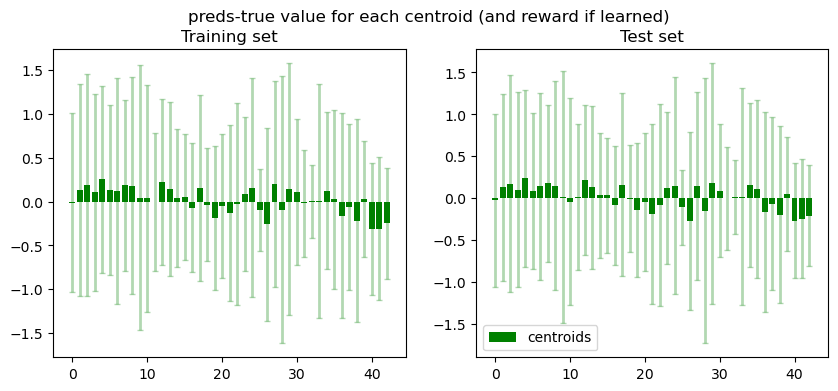

In [ ]:
with torch.no_grad():  # we don't need gradients in the testing phase
    train_preds = train_fake_preds
    test_preds = test_fake_preds

relative_train_preds_mean = torch.mean(train_preds - train_y[:, :-1], axis=0)
relative_train_preds_std = torch.std(train_preds - train_y[:, :-1], axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y[:, :-1], axis=0)
relative_test_preds_std = torch.std(test_preds - test_y[:, :-1], axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Colors and labels
if len(relative_train_preds_mean) < num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean) == num_centroids:
    color = "green"
    label = "centroids"
else:
    colors = ["green"] * num_centroids
    colors.append("red")
    label = ["centroids"] * num_centroids
    label.append("reward")

# Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(x, relative_train_preds_mean, color=colors, label=label)
for pos, y, err, color in zip(
    x, relative_train_preds_mean, relative_train_preds_std, colors
):
    ax[0].errorbar(pos, y, err, lw=2, capsize=2, capthick=1, color=color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text("Training set")

# Test bar plots
ax[1].bar(x, relative_test_preds_mean, color=colors, label=label)
for pos, y, err, color in zip(
    x, relative_test_preds_mean, relative_test_preds_std, colors
):
    ax[1].errorbar(pos, y, err, lw=2, capsize=2, capthick=1, color=color, alpha=0.3)
ax[1].title.set_text("Test set")

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="best")
plt.show()

### Train Model: Reward and dynamics separately

Only dynamics

In [51]:
dynamics_train_x = train_x
dynamics_train_y = train_y[:, :-1]
dynamics_test_x = test_x
dynamics_test_y = test_y[:, :-1]

print(
    dynamics_train_x.shape,
    dynamics_train_y.shape,
    dynamics_test_x.shape,
    dynamics_test_y.shape,
)

torch.Size([8000, 44]) torch.Size([8000, 43]) torch.Size([2000, 44]) torch.Size([2000, 43])


In [52]:
learningRate = 0.01
epochs = 2000
eval_epoch_freq = 1
in_size = dynamics_train_x.shape[-1]
out_size = dynamics_train_y.shape[-1]
device = "cpu"
dynamics_lr_model = LinearRegression(in_size, out_size, device)
criterion = torch.nn.MSELoss()
metric = r2_score
optimizer = torch.optim.SGD(dynamics_lr_model.parameters(), lr=learningRate)

In [53]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    torch.manual_seed(epoch)
    idx = torch.randperm(dynamics_train_x.shape[0])
    dynamics_train_x = dynamics_train_x[idx, :]
    dynamics_train_y = dynamics_train_y[idx, :]
    idx = torch.randperm(test_x.shape[0])
    dynamics_test_x = dynamics_test_x[idx, :]
    dynamics_test_y = dynamics_test_y[idx, :]
    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = dynamics_lr_model(dynamics_train_x)

    # get loss for the predicted output
    loss = criterion(outputs, dynamics_train_y)
    train_losses.append(loss.item())
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    # Compute metric
    train_metric = metric(outputs, dynamics_train_y)
    train_metrics.append(train_metric)

    print("epoch {}, loss {}, R2 {}".format(epoch, loss.item(), train_metric))

    if epoch % eval_epoch_freq == 0:
        with torch.no_grad():  # we don't need gradients in the testing phase
            preds = dynamics_lr_model(dynamics_test_x)
            test_loss = criterion(preds, dynamics_test_y)
            test_losses.append(test_loss.item())
            # Compute metric
            test_metric = metric(preds, dynamics_test_y)
            test_metrics.append(test_metric)
            print("Eval loss {}, R2 {}".format(test_loss.item(), test_metric))

epoch 0, loss 7.579585075378418, R2 -1.2256653308868408
Eval loss 7.2239251136779785, R2 -1.0983457565307617
epoch 1, loss 7.25657844543457, R2 -1.1373687982559204
Eval loss 6.935920238494873, R2 -1.0201694965362549
epoch 2, loss 6.962957859039307, R2 -1.0571080446243286
Eval loss 6.674193859100342, R2 -0.9491091966629028
epoch 3, loss 6.695937633514404, R2 -0.9841214418411255
Eval loss 6.436247825622559, R2 -0.8844888210296631
epoch 4, loss 6.452997207641602, R2 -0.917719841003418
Eval loss 6.21981954574585, R2 -0.8256970047950745
epoch 5, loss 6.231855392456055, R2 -0.8572792410850525
Eval loss 6.022862434387207, R2 -0.7721801400184631
epoch 6, loss 6.0304484367370605, R2 -0.8022348284721375
Eval loss 5.843524932861328, R2 -0.7234376072883606
epoch 7, loss 5.846907138824463, R2 -0.7520757913589478


Eval loss 5.680130958557129, R2 -0.67901611328125
epoch 8, loss 5.679541110992432, R2 -0.7063394784927368
Eval loss 5.531164646148682, R2 -0.6385055184364319
epoch 9, loss 5.526818752288818, R2 -0.6646074056625366
Eval loss 5.395254611968994, R2 -0.6015348434448242
epoch 10, loss 5.387355327606201, R2 -0.6265006065368652
Eval loss 5.2711591720581055, R2 -0.5677680373191833
epoch 11, loss 5.259896755218506, R2 -0.5916762351989746
Eval loss 5.1577558517456055, R2 -0.5369014143943787
epoch 12, loss 5.143309593200684, R2 -0.5598240494728088
Eval loss 5.054027080535889, R2 -0.5086598992347717
epoch 13, loss 5.03656530380249, R2 -0.5306631326675415
Eval loss 4.9590559005737305, R2 -0.4827946126461029
epoch 14, loss 4.938735485076904, R2 -0.5039392709732056
Eval loss 4.872008800506592, R2 -0.4590804874897003
epoch 15, loss 4.8489789962768555, R2 -0.4794224500656128
Eval loss 4.792133331298828, R2 -0.4373137354850769
epoch 16, loss 4.766534328460693, R2 -0.45690447092056274
Eval loss 4.71875, 

<Figure size 640x480 with 0 Axes>

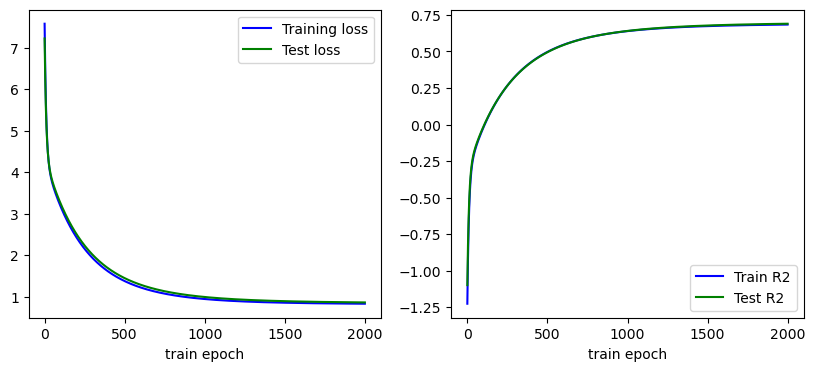

In [54]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, "b", label="Training loss")
ax[0].plot(test_losses, "g", label="Test loss")
ax[1].plot(train_metrics, "b", label="Train R2")
ax[1].plot(test_metrics, "g", label="Test R2")
ax[0].set_xlabel("train epoch")
ax[1].set_xlabel("train epoch")
ax[0].legend(loc="best")
ax[1].legend(loc="best")
plt.show()

<Figure size 640x480 with 0 Axes>

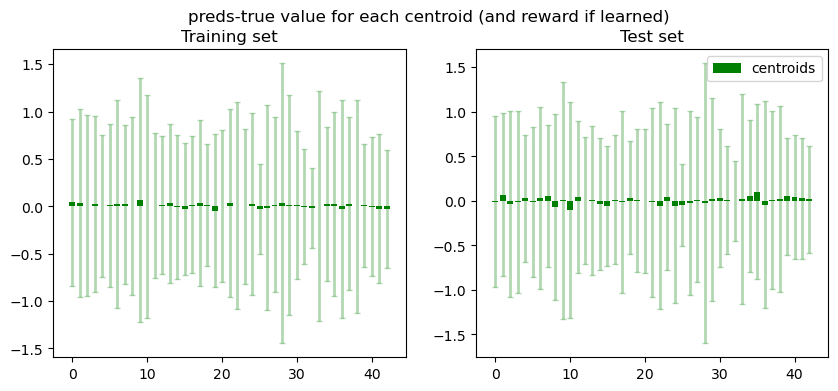

In [55]:
with torch.no_grad():  # we don't need gradients in the testing phase
    train_preds = dynamics_lr_model(dynamics_train_x)
    test_preds = dynamics_lr_model(dynamics_test_x)

relative_train_preds_mean = torch.mean(train_preds - dynamics_train_y, axis=0)
relative_train_preds_std = torch.std(train_preds - dynamics_train_y, axis=0)
relative_test_preds_mean = torch.mean(test_preds - dynamics_test_y, axis=0)
relative_test_preds_std = torch.std(test_preds - dynamics_test_y, axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Colors and labels
if len(relative_train_preds_mean) < num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean) == num_centroids:
    color = "green"
    label = "centroids"
else:
    colors = ["green"] * num_centroids
    colors.append("red")
    label = ["centroids"] * num_centroids
    label.append("reward")

# Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(x, relative_train_preds_mean, color=colors, label=label)
for pos, y, err, color in zip(
    x, relative_train_preds_mean, relative_train_preds_std, colors
):
    ax[0].errorbar(pos, y, err, lw=2, capsize=2, capthick=1, color=color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text("Training set")

# Test bar plots
ax[1].bar(x, relative_test_preds_mean, color=colors, label=label)
for pos, y, err, color in zip(
    x, relative_test_preds_mean, relative_test_preds_std, colors
):
    ax[1].errorbar(pos, y, err, lw=2, capsize=2, capthick=1, color=color, alpha=0.3)
ax[1].title.set_text("Test set")

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="best")
plt.show()

Only reward

In [23]:
reward_train_x = train_x
reward_train_y = train_y[:, -1][..., None]
reward_test_x = test_x
reward_test_y = test_y[:, -1][..., None]

print(
    reward_train_x.shape, reward_train_y.shape, reward_test_x.shape, reward_test_y.shape
)

torch.Size([800, 44]) torch.Size([800, 1]) torch.Size([200, 44]) torch.Size([200, 1])


In [24]:
from src.model.linear_regression import LinearRegression

learningRate = 0.05
epochs = 2000
eval_epoch_freq = 1
in_size = reward_train_x.shape[-1]
out_size = reward_train_y.shape[-1]
device = "cpu"
reward_lr_model = LinearRegression(in_size, out_size, device)
criterion = torch.nn.MSELoss()
metric = r2_score
optimizer = torch.optim.SGD(reward_lr_model.parameters(), lr=learningRate)

In [71]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    torch.manual_seed(epoch)
    idx = torch.randperm(reward_train_x.shape[0])
    reward_train_x = reward_train_x[idx, :]
    reward_train_y = reward_train_y[idx, :]
    idx = torch.randperm(test_x.shape[0])
    reward_test_x = reward_test_x[idx, :]
    reward_test_y = reward_test_y[idx, :]
    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = reward_lr_model(reward_train_x)

    # get loss for the predicted output
    loss = criterion(outputs.squeeze(), reward_train_y.squeeze())
    train_losses.append(loss.item())
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    # Compute metric
    train_metric = metric(outputs.squeeze(), reward_train_y.squeeze())
    train_metrics.append(train_metric)

    print("epoch {}, loss {}, R2 {}".format(epoch, loss.item(), train_metric))

    if epoch % eval_epoch_freq == 0:
        with torch.no_grad():  # we don't need gradients in the testing phase
            preds = reward_lr_model(reward_test_x)
            test_loss = criterion(preds.squeeze(), reward_test_y.squeeze())
            test_losses.append(test_loss.item())
            # Compute metric
            test_metric = metric(preds.squeeze(), reward_test_y.squeeze())
            test_metrics.append(test_metric)
            print("Eval loss {}, R2 {}".format(test_loss.item(), test_metric))

epoch 0, loss 0.09437771141529083, R2 -2.828277587890625
Eval loss 0.1160796731710434, R2 -2.738022804260254
epoch 1, loss 0.08736592531204224, R2 -2.5438544750213623
Eval loss 0.11290904879570007, R2 -2.6359217166900635
epoch 2, loss 0.08277229219675064, R2 -2.3575215339660645
Eval loss 0.11074014008045197, R2 -2.566077947616577
epoch 3, loss 0.0796939879655838, R2 -2.2326550483703613
Eval loss 0.10917405784130096, R2 -2.515645742416382
epoch 4, loss 0.07755535840988159, R2 -2.1459062099456787
Eval loss 0.10797608643770218, R2 -2.4770681858062744
epoch 5, loss 0.0760030448436737, R2 -2.0829405784606934
Eval loss 0.10700736194849014, R2 -2.445873260498047
epoch 6, loss 0.07482103258371353, R2 -2.03499174118042
Eval loss 0.10618427395820618, R2 -2.419368028640747
epoch 7, loss 0.07387606799602509, R2 -1.996659517288208
Eval loss 0.10545536130666733, R2 -2.3958964347839355
epoch 8, loss 0.0730847418308258, R2 -1.964561939239502
Eval loss 0.10478820651769638, R2 -2.3744125366210938
epoch 

epoch 40, loss 0.057117655873298645, R2 -1.3168835639953613
Eval loss 0.08672632277011871, R2 -1.7927799224853516
epoch 41, loss 0.05666763335466385, R2 -1.2986290454864502
Eval loss 0.08615706115961075, R2 -1.7744483947753906
epoch 42, loss 0.0562206469476223, R2 -1.2804961204528809
Eval loss 0.08558791875839233, R2 -1.7561209201812744
epoch 43, loss 0.05577678233385086, R2 -1.2624931335449219
Eval loss 0.08501900732517242, R2 -1.7378005981445312
epoch 44, loss 0.055336106568574905, R2 -1.2446179389953613
Eval loss 0.08445043861865997, R2 -1.7194905281066895
epoch 45, loss 0.054898716509342194, R2 -1.2268757820129395
Eval loss 0.08388233929872513, R2 -1.7011973857879639
epoch 46, loss 0.05446465313434601, R2 -1.2092688083648682
Eval loss 0.08331482857465744, R2 -1.682922124862671
epoch 47, loss 0.05403400957584381, R2 -1.1918003559112549
Eval loss 0.08274804800748825, R2 -1.6646699905395508
epoch 48, loss 0.05360683053731918, R2 -1.1744725704193115
Eval loss 0.08218209445476532, R2 -1

In [29]:
# TEST with model trainer
import omegaconf

from src.env.bikes import Bikes
from src.model.dict_model_wrapper import OneDTransitionRewardModelDictSpace
from src.util.model_trainer import ModelTrainerOverriden, MultiModelsTrainer
from src.util.replay_buffer import ReplayBufferOverriden
import mbrl.util.common

# WARNING: Make sure that it makes sense with trained model above

# Env config
env_config = {
    "num_trucks": 5,  # 10
    "action_per_day": 8,
    "next_day_method": "random",  # sequential
    "initial_distribution": "zeros",
    "bikes_per_truck": 5,
    "start_walk_dist_max": 0.2,
    "end_walk_dist_max": 1000.0,
    "trip_duration": 0.5,
    "past_trip_data": "src/env/bikes_data/all_trips_LouVelo_merged.csv",
    "weather_data": "src/env/bikes_data/weather_data.csv",
    "centroids_coord": "src/env/bikes_data/LouVelo_centroids_coords.npy",
    # "centroids_idx": #[93,83,80,98,6,84,87,99,56,97], #Number of centroids or list of indices
    "station_dependencies": None,  # src/env/bikes_data/factors_radius_3.npy
}

# Params
seed = 1
device = "cpu"
target_is_delta = False #Falses
normalize = False
use_double_dtype = False  # True
optim_lr = 0.0001 #learningRate
model_wd = 0.000001
model_batch_size = dataset_size
validation_ratio = test_split_ratio
num_epochs = 500 #epochs

# Env
env_config = omegaconf.DictConfig(env_config)
env = Bikes(env_config, render_mode=None)

obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

# Seed
# rng = np.random.default_rng(seed=seed)
# torch_generator = torch.Generator(device=device)
# if seed is not None:
#     torch_generator.manual_seed(seed)
rng = np.random.default_rng(seed=0)
torch.manual_seed(0)

# Dynamics model
from src.model.simple import Simple, FactoredSimple
from src.model.gaussian_process import MultiOutputGP
from src.util.util import get_base_dir_path

dynamics_model = OneDTransitionRewardModelDictSpace(
    Simple(44, 1, device), #factors, num_layers=2, hid_size=100),
    map_obs=env.map_obs,
    map_act=env.map_act,
    rescale_obs=env.rescale_obs,
    rescale_act=env.rescale_act,
    model_input_obs_key=input_obs_keys,
    model_input_act_key=[],
    model_output_key=[],
    obs_preprocess_fn=env.obs_preprocess_fn,
    obs_postprocess_fn=env.obs_postprocess_fn,
    target_is_delta=target_is_delta,
    normalize=normalize,
    normalize_double_precision=use_double_dtype,
    learned_rewards=True,
    no_delta_list=None,
    num_elites=None,
)

# Model trainer
model_trainer = ModelTrainerOverriden(
    model=dynamics_model,
    optim_lr=optim_lr,
    weight_decay=model_wd,
    logger=None,
)

# Load replay Buffer
dtype = np.double if use_double_dtype else np.float32
replay_buffer = ReplayBufferOverriden(
    1000,
    obs_shape,
    act_shape,
    obs_type=dtype,
    action_type=dtype,
    reward_type=dtype,
    rng=rng,
    # max_trajectory_length=None,
)

load_dir = pathlib.Path(load_dir)
replay_buffer.load(str(load_dir), num_to_store=1000)

dataset_train, dataset_val = mbrl.util.common.get_basic_buffer_iterators(
    replay_buffer,
    model_batch_size,
    validation_ratio,
    ensemble_size=len(dynamics_model),
    shuffle_each_epoch=True,
    bootstrap_permutes=False,
)

if hasattr(dynamics_model, "update_normalizer"):
    dynamics_model.update_normalizer(replay_buffer.get_all())
train_losses, test_losses, train_metrics, test_metrics = model_trainer.train(
    dataset_train,
    dataset_val,
    num_epochs=num_epochs,
    patience=num_epochs,
    evaluate=True,
    debug=True,
)

Training epoch duration: 0.02s
Epoch: 0 Train loss 0.215, Test loss 0.177 Train R2 -7.152, Test R2 -6.301 
Training epoch duration: 0.02s
Epoch: 1 Train loss 0.176, Test loss 0.143 Train R2 -5.663, Test R2 -4.883 
Training epoch duration: 0.02s
Epoch: 2 Train loss 0.142, Test loss 0.114 Train R2 -4.395, Test R2 -3.688 
Training epoch duration: 0.02s
Epoch: 3 Train loss 0.114, Test loss 0.089 Train R2 -3.324, Test R2 -2.691 
Training epoch duration: 0.02s
Epoch: 4 Train loss 0.091, Test loss 0.069 Train R2 -2.427, Test R2 -1.862 
Training epoch duration: 0.02s
Epoch: 5 Train loss 0.071, Test loss 0.053 Train R2 -1.685, Test R2 -1.190 
Training epoch duration: 0.02s
Epoch: 6 Train loss 0.055, Test loss 0.040 Train R2 -1.078, Test R2 -0.657 
Training epoch duration: 0.02s
Epoch: 7 Train loss 0.042, Test loss 0.031 Train R2 -0.592, Test R2 -0.259 
Training epoch duration: 0.02s
Epoch: 8 Train loss 0.032, Test loss 0.024 Train R2 -0.221, Test R2 0.009 
Training epoch duration: 0.02s
Epoch: 

<Figure size 640x480 with 0 Axes>

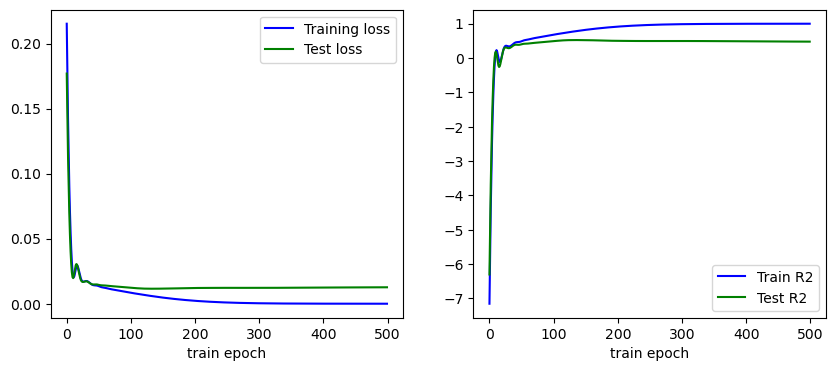

In [30]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, "b", label="Training loss")
ax[0].plot(test_losses, "g", label="Test loss")
ax[1].plot(train_metrics, "b", label="Train R2")
ax[1].plot(test_metrics, "g", label="Test R2")
ax[0].set_xlabel("train epoch")
ax[1].set_xlabel("train epoch")
ax[0].legend(loc="best")
ax[1].legend(loc="best")
plt.show()

<Figure size 640x480 with 0 Axes>

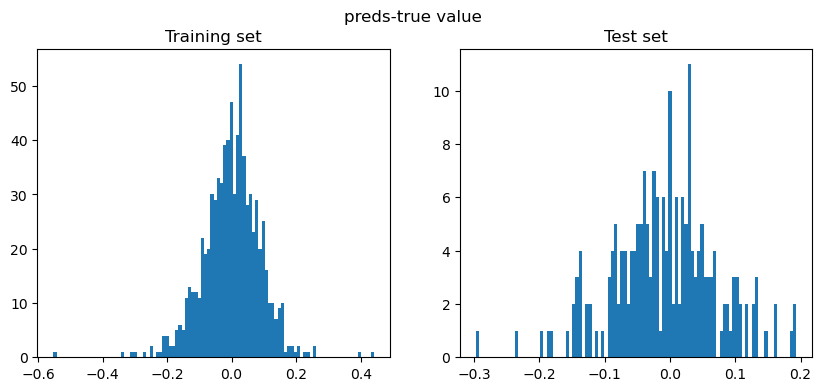

In [32]:
with torch.no_grad():  # we don't need gradients in the testing phase
    train_preds = dynamics_model.model(reward_train_x)
    test_preds = dynamics_model.model(reward_test_x)

relative_train_preds = train_preds - reward_train_y
relative_test_preds = test_preds - reward_test_y

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Train bar plots
n_bins = 100
counts, bins = np.histogram(relative_train_preds, bins=n_bins)
ax[0].hist(bins[:-1], bins, weights=counts)
ax[0].title.set_text("Training set")

# Test bar plots
n_bins = 100
counts, bins = np.histogram(relative_test_preds, bins=n_bins)
ax[1].hist(bins[:-1], bins, weights=counts)
ax[1].title.set_text("Test set")

fig.suptitle("preds-true value")
plt.show()

### 3. The MBRL agent

Parameters

In [51]:
import omegaconf

import mbrl
import mbrl.models
import mbrl.planning
from src.env.bikes import Bikes
from src.model.dict_model_wrapper import OneDTransitionRewardModelDictSpace

# WARNING: Make sure that it makes sense with trained model above

# Env config
env_config = {
    "num_trucks": 5,  # 10
    "action_per_day": 8,
    "next_day_method": "random",  # sequential
    "initial_distribution": "zeros",
    "bikes_per_truck": 5,
    "start_walk_dist_max": 0.2,
    "end_walk_dist_max": 1000.0,
    "trip_duration": 0.5,
    "past_trip_data": "src/env/bikes_data/all_trips_LouVelo_merged.csv",
    "weather_data": "src/env/bikes_data/weather_data.csv",
    "centroids_coord": "src/env/bikes_data/LouVelo_centroids_coords.npy",
    # "centroids_idx": #[93,83,80,98,6,84,87,99,56,97], #Number of centroids or list of indices
    "station_dependencies": None,  # src/env/bikes_data/factors_radius_3.npy
}

# Params
seed = 0
device = "cpu"
num_episodes = 10
num_steps = num_episodes * env_config["action_per_day"]
initial_exploration_steps = 500
target_is_delta = False
normalize = False
use_double_dtype = False  # True
num_particles = 20

# Agent config
optimizer_cfg = {
    "_target_": "mbrl.planning.CEMOptimizer",
    "num_iterations": 5,
    "elite_ratio": 0.1,
    "population_size": 350,
    "alpha": 0.1,
    "lower_bound": None,
    "upper_bound": None,
    "return_mean_elites": True,
    "device": device,
    "clipped_normal": False,
}

The important building blocks

In [52]:
# Env
env_config = omegaconf.DictConfig(env_config)
env = Bikes(env_config, render_mode=None)

obs_shape = env.observation_space.shape
act_shape = env.action_space.shape
print(obs_shape, act_shape)

# Seed
rng = np.random.default_rng(seed=seed)
torch_generator = torch.Generator(device=device)
if seed is not None:
    torch_generator.manual_seed(seed)

# Dynamics model
model = lr_model

dynamics_model = OneDTransitionRewardModelDictSpace(
    model,
    map_obs=env.map_obs,
    map_act=env.map_act,
    rescale_obs=env.rescale_obs,
    rescale_act=env.rescale_act,
    model_input_obs_key=input_obs_keys,
    model_input_act_key=input_act_keys,
    model_output_key=output_keys,
    obs_preprocess_fn=env.obs_preprocess_fn,
    obs_postprocess_fn=env.obs_postprocess_fn,
    target_is_delta=target_is_delta,
    normalize=normalize,
    normalize_double_precision=use_double_dtype,
    learned_rewards=learned_rewards,
    no_delta_list=None,
    num_elites=None,
)

# Model Env
model_env = mbrl.models.ModelEnv(
    env, dynamics_model, env.termination_fn, None, generator=torch_generator
)

# Agent
optimizer_cfg = omegaconf.DictConfig(optimizer_cfg)
agent = mbrl.planning.TrajectoryOptimizerAgent(
    optimizer_cfg=optimizer_cfg,
    action_lb=env.action_space.low,
    action_ub=env.action_space.high,
    planning_horizon=env.action_per_day,
    replan_freq=1,
)


def trajectory_eval_fn(initial_state, action_sequences):
    return model_env.evaluate_action_sequences(
        action_sequences, initial_state=initial_state, num_particles=num_particles
    )


agent.set_trajectory_eval_fn(trajectory_eval_fn)

(46,) (10,)


RL loop (with pretrained model)

In [55]:
import warnings

warnings.filterwarnings("ignore")

env_steps = 0
current_trial = 0
rewards = np.empty((num_episodes, env_config["action_per_day"]))

while current_trial < num_episodes:
    obs, _ = env.reset()
    agent.reset()
    terminated = False
    truncated = False
    total_reward = 0.0
    steps_trial = 0

    # Make 1 episode
    while not terminated and not truncated:
        # --- Doing env step using the agent ---
        action = agent.act(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        rewards[current_trial, steps_trial] = reward

        obs = next_obs
        total_reward += reward
        steps_trial += 1
        env_steps += 1

        # print(f"Step {env_steps}: Reward {reward:.3f}.")

    current_trial += 1
    print(f"Trial: {current_trial }, reward: {total_reward}.")

Trial: 1, reward: 2.573672088377971.
Trial: 2, reward: 2.705402098585997.
Trial: 3, reward: 2.322563968184047.
Trial: 4, reward: 2.677491420881591.
Trial: 5, reward: 2.8242376956986925.
Trial: 6, reward: 3.101734248162826.
Trial: 7, reward: 1.843696885892893.
Trial: 8, reward: 1.903616935018447.
Trial: 9, reward: 2.8298462815498127.
Trial: 10, reward: 2.7504850048228.


Text(0, 0.5, 'Cumulative Reward')

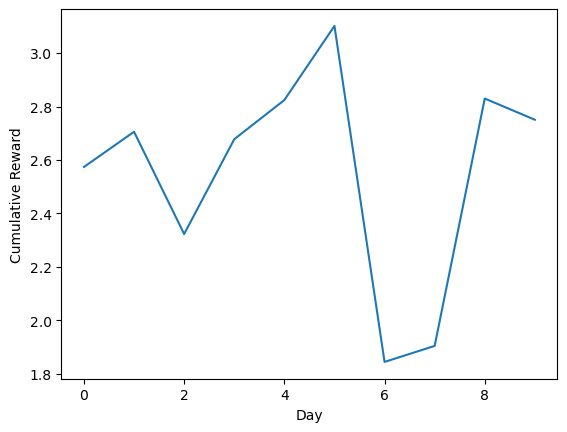

In [56]:
plt.plot(np.sum(rewards, axis=-1))
plt.xlabel("Day")
plt.ylabel("Cumulative Reward")

### 4. Training MBRL agent with a pretrained model

Parameters

In [104]:
from typing import Optional
import omegaconf

import mbrl
import mbrl.models
import mbrl.planning
from mbrl.models.model import Model
from mbrl.util.logger import Logger
import mbrl.util.common
import mbrl.models

from src.util.replay_buffer import ReplayBufferOverriden
from src.util.model_trainer import ModelTrainer, ModelTrainerOverriden
from src.env.bikes import Bikes
from src.model.dict_model_wrapper import OneDTransitionRewardModelDictSpace
from src.model.simple import Simple

# WARNING: Make sure that it makes sense with trained model above

# Env config
env_config = {
    "num_trucks": 5,  # 10
    "action_per_day": 8,
    "next_day_method": "random",  # sequential
    "initial_distribution": "zeros",
    "bikes_per_truck": 5,
    "start_walk_dist_max": 0.2,
    "end_walk_dist_max": 1000.0,
    "trip_duration": 0.5,
    "past_trip_data": "src/env/bikes_data/all_trips_LouVelo_merged.csv",
    "weather_data": "src/env/bikes_data/weather_data.csv",
    "centroids_coord": "src/env/bikes_data/LouVelo_centroids_coords.npy",
    # "centroids_idx": #[93,83,80,98,6,84,87,99,56,97], #Number of centroids or list of indices
    "station_dependencies": None,  # src/env/bikes_data/factors_radius_3.npy
}

# Params
seed = 0
device = "cpu"
num_episodes = 20
num_steps = num_episodes * env_config["action_per_day"]
initial_exploration_steps = 500
target_is_delta = False
normalize = False
use_double_dtype = False  # True
num_particles = 20
optim_lr = 0.1
model_wd = 0
freq_train_model = 10
model_batch_size = num_steps + initial_exploration_steps  # Make sense for LR or GP
validation_ratio = 0
num_epochs = 25

# Agent config
optimizer_cfg = {
    "_target_": "mbrl.planning.CEMOptimizer",
    "num_iterations": 5,
    "elite_ratio": 0.1,
    "population_size": 350,
    "alpha": 0.1,
    "lower_bound": None,
    "upper_bound": None,
    "return_mean_elites": True,
    "device": device,
    "clipped_normal": False,
}

Important building blocks

In [105]:
# Env
env_config = omegaconf.DictConfig(env_config)
env = Bikes(env_config, render_mode=None)

obs_shape = env.observation_space.shape
act_shape = env.action_space.shape
print(obs_shape, act_shape)

# Seed
rng = np.random.default_rng(seed=seed)
torch_generator = torch.Generator(device=device)
if seed is not None:
    torch_generator.manual_seed(seed)

# Dynamics model
model = Simple(in_size, out_size, device)

dynamics_model = OneDTransitionRewardModelDictSpace(
    model,
    map_obs=env.map_obs,
    map_act=env.map_act,
    rescale_obs=env.rescale_obs,
    rescale_act=env.rescale_act,
    model_input_obs_key=input_obs_keys,
    model_input_act_key=input_act_keys,
    model_output_key=output_keys,
    obs_preprocess_fn=env.obs_preprocess_fn,
    obs_postprocess_fn=env.obs_postprocess_fn,
    target_is_delta=target_is_delta,
    normalize=normalize,
    normalize_double_precision=use_double_dtype,
    learned_rewards=learned_rewards,
    no_delta_list=None,
    num_elites=None,
)

# Model Env
model_env = mbrl.models.ModelEnv(
    env, dynamics_model, env.termination_fn, None, generator=torch_generator
)

# Agent
optimizer_cfg = omegaconf.DictConfig(optimizer_cfg)
agent = mbrl.planning.TrajectoryOptimizerAgent(
    optimizer_cfg=optimizer_cfg,
    action_lb=env.action_space.low,
    action_ub=env.action_space.high,
    planning_horizon=env.action_per_day,
    replan_freq=1,
)


def trajectory_eval_fn(initial_state, action_sequences):
    return model_env.evaluate_action_sequences(
        action_sequences, initial_state=initial_state, num_particles=num_particles
    )


agent.set_trajectory_eval_fn(trajectory_eval_fn)

# Model trainer
model_trainer = ModelTrainerOverriden(
    model=dynamics_model,
    optim_lr=optim_lr,
    weight_decay=model_wd,
    logger=None,
)


# Replay Buffer
dtype = np.double if use_double_dtype else np.float32
replay_buffer = ReplayBufferOverriden(
    num_steps + initial_exploration_steps,
    obs_shape,
    act_shape,
    obs_type=dtype,
    action_type=dtype,
    reward_type=dtype,
    rng=rng,
    # max_trajectory_length=None,
)

load_dir = pathlib.Path(load_dir)
replay_buffer.load(str(load_dir), num_to_store=initial_exploration_steps)

(46,) (10,)


Training MBRL loop

In [106]:
import warnings

warnings.filterwarnings("ignore")

env_steps = 0
current_trial = 0
rewards = np.empty((num_episodes, env_config["action_per_day"]))
all_training_losses = []
all_val_scores = []

while current_trial < num_episodes:
    obs, _ = env.reset()
    agent.reset()
    terminated = False
    truncated = False
    total_reward = 0.0
    steps_trial = 0

    # Make 1 episode
    while not terminated and not truncated:
        # --------------- Model Training -----------------
        if env_steps % freq_train_model == 0:
            dataset_train, dataset_val = mbrl.util.common.get_basic_buffer_iterators(
                replay_buffer,
                model_batch_size,
                validation_ratio,
                ensemble_size=len(dynamics_model),
                shuffle_each_epoch=True,
                bootstrap_permutes=False,
            )
            if hasattr(dynamics_model, "update_normalizer"):
                dynamics_model.update_normalizer(replay_buffer.get_all())
            training_losses, val_scores = model_trainer.train(
                dataset_train,
                dataset_val=dataset_val,
                num_epochs=num_epochs,
                patience=num_epochs,
                improvement_threshold=0.01,
            )
            all_training_losses += training_losses
            all_val_scores += val_scores
            print(
                f"Mean train loss: {np.mean(training_losses):.3f} Mean val score: {np.mean(val_scores):.3f}"
            )

        # --- Doing env step using the agent and adding to model dataset ---
        action = agent.act(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        replay_buffer.add(obs, action, next_obs, reward, terminated, truncated)

        model_action = action[None, ...]
        model_observation = {
            "obs": obs[None, ...],
            "propagation_indices": None,
        }
        model_next_obs, model_reward, model_dones, next_model_state = model_env.step(
            model_action, model_observation
        )
        # TODO: compare actual next_obs and rewards with model env
        print(
            next_obs - torch.round(model_next_obs).numpy(),
            reward - model_reward.numpy(),
            terminated,
        )

        rewards[current_trial, steps_trial] = reward

        obs = next_obs
        total_reward += reward
        steps_trial += 1
        env_steps += 1

        print(f"Step {env_steps}: Reward {reward:.3f}.")

    current_trial += 1
    print(f"Trial: {current_trial }, reward: {total_reward}.")

1 500
Epoch: 0 Train loss 5.370, Test loss 864915072.000
1 500
Epoch: 1 Train loss 864915200.000, Test loss 281.795
1 500
Epoch: 2 Train loss 281.795, Test loss 5.353
1 500
Epoch: 3 Train loss 5.353, Test loss 5.373
1 500
Epoch: 4 Train loss 5.373, Test loss 5.311
1 500
Epoch: 5 Train loss 5.311, Test loss 5.156
1 500
Epoch: 6 Train loss 5.156, Test loss 4.905
1 500
Epoch: 7 Train loss 4.905, Test loss 4.582
1 500
Epoch: 8 Train loss 4.582, Test loss 4.256
1 500
Epoch: 9 Train loss 4.256, Test loss 4.038
1 500
Epoch: 10 Train loss 4.038, Test loss 4.029
1 500
Epoch: 11 Train loss 4.029, Test loss 4.146
1 500
Epoch: 12 Train loss 4.146, Test loss 4.144
1 500
Epoch: 13 Train loss 4.144, Test loss 4.023
1 500
Epoch: 14 Train loss 4.023, Test loss 3.897
1 500
Epoch: 15 Train loss 3.897, Test loss 3.841
1 500
Epoch: 16 Train loss 3.841, Test loss 3.855
1 500
Epoch: 17 Train loss 3.855, Test loss 3.906
1 500
Epoch: 18 Train loss 3.906, Test loss 3.956
1 500
Epoch: 19 Train loss 3.956, Test l

<Figure size 640x480 with 0 Axes>

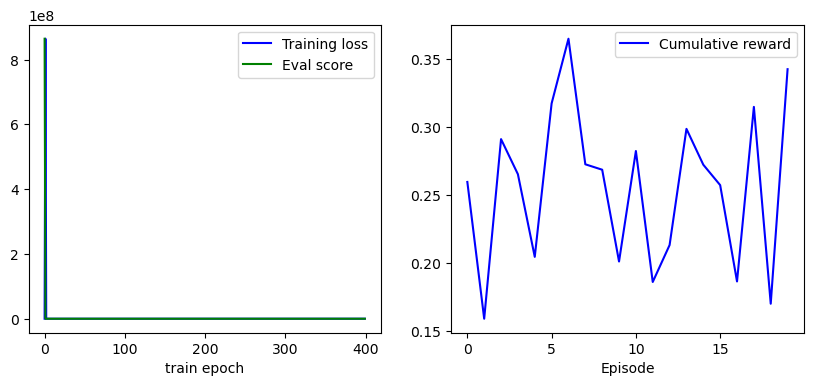

In [107]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(all_training_losses, "b", label="Training loss")
ax[0].plot(all_val_scores, "g", label="Eval score")
ax[0].set_xlabel("train epoch")
ax[1].plot(np.mean(rewards, axis=-1), "b", label="Cumulative reward")
ax[1].set_xlabel("Episode")
ax[0].legend(loc="best")
ax[1].legend(loc="best")
plt.show()